In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# import resource

In [215]:
def find_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/(4*N)) * np.sum(Z) + 2*lambda_
    
    return L

def find_smallest_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.min(Z) + 2*lambda_
    
    return L

def find_median_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.median(Z) + 2*lambda_
    
    return L

def find_mean_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.mean(Z) + 2*lambda_
    
    return L

In [216]:
## Preprocessing of data
# Load data here:

N_sites = 2921
N_cols = 327
dghg = 15
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

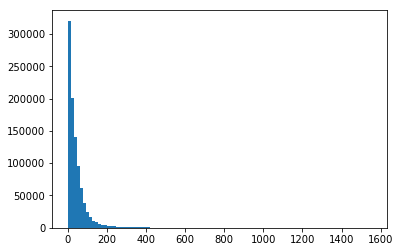

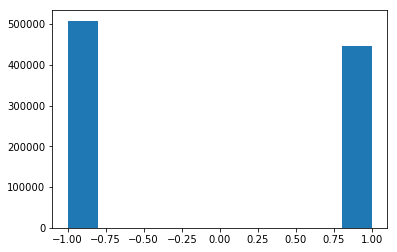

In [217]:
X = ghgdata[:, 0:dghg]
Y = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Y, bins=100)

# threshold Y to binary
threshold = 30
mask = Y < threshold
Y[mask] = -1
Y[~mask] = 1
plt.figure(2)
_ = plt.hist(Y)

In [218]:
# Split train and test data here: (X_train, Y_train, X_test, Y_test)

N_train = math.floor(Nghg*0.75)
N_test = math.floor(Nghg*0.25) + 1

N_train = 1000
N_test = 1000

# train_idx = np.random.choice(Nghg, size=N_train, replace=False)
train_idx = np.arange(N_train)
X_train = X[train_idx, :]
Y_train = Y[train_idx]

# test_idx_bool = ~np.isin(np.arange(Nghg), train_idx)
test_idx = np.arange(N_train, N_train + N_test)
X_test = X[test_idx, :]
Y_test = Y[test_idx]

#### Logistic Ridge regression
$$ f(x) = \frac{1}{N}\sum_{i\in[N]} f_i(x) + \lambda\lVert w \rVert_2^2 $$
has the gradient: 
$$ \nabla f(x) = \frac{1}{N}\sum_{i\in[N]} \nabla f_i(x) + 2\lambda w, $$
$$ \nabla f_i(x) = -y_i x_i \frac{e^{-y_ix_i^T w}}{1 + e^{-y_ix_i^T w}} = -y_i x_i \frac{1}{1 + e^{y_i x_i^T w}}.$$
Computing the gradient in the form as shown here, the exponential can take "inf" values and the fraction becomes NaN.
We rewrite it as:

$$ \nabla f_i(x) = -y_i x_i \exp\{-y_i x_i^T w - \log(1+\exp\{-y_i x_i^T w\})\} $$
this way, whenever the inner exponential takes "inf", the log will take "inf" and the outer exponential will take "0".


In [267]:
## Logistic ridge regression with different optimizers
# cost function and gradient calculation

def cost(x, y, w, lambda_ = 0.01):
    N, d = x.shape
    value = 0
    for i in range(N):
        Z = -1 * y[i] * w.T @ (x[i, :]).reshape(d, 1)
        value += np.log(1 + np.exp(Z))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
#     set_trace()
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N,d)
    YXw = YX @ w # (N,1)
    exp_vec = 1/(1 + np.exp(YXw)) # (N,1)
    grad_array = -YX * exp_vec # (N,d)
    output = np.sum(grad_array, axis=0) # (1,d)
    output = (1/N) * output.reshape(d,1) + 2 * lambda_ * w # (d,1)
    return output # (d,1)

def function_gradient_logs(X, Y, w, lambda_):
#     set_trace()
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N, d)
    YXw = YX @ w # (N, 1)
    exponential_vec = - YXw - np.log(1 + np.exp(-YXw)) # (N, 1)
    all_gradients = -YX * np.exp(exponential_vec) # (N, d)
    output = (1/N) * np.sum(all_gradients, axis=0).reshape(d,1) + 2*lambda_*w
    return output # (d, 1)
    

In [691]:
# ---------------------- Complete the blank definitions: --------------------------------------

def solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False):
    cost_ = np.zeros(num_iters)
    if (optimizer == "GD"):
        for i in range(num_iters):
#             set_trace()
            g = function_gradient(x, y, w, lambda_) # compute the exact gradient wrt w, given x and y
            w = w - alpha * g # GD update
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                        
            if (np.linalg.norm(g) <= epsilon):
                print("Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
                break
#         print("Number of iterations: ", num_iters, "/", num_iters)
#         print("final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        N, d = x.shape
        assert y.shape == (N,1)
        for i in range(num_iters):            
            # randomize what data point to estimate gradient with
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :]
            y_ = y[[i_], :]
            
            g = function_gradient(x_, y_, w, lambda_) # compute gradient
            w = w - alpha * g # GD update 
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 100 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
            
#         print("Number of epochs: ", K)
#         print("Number of iteraions: ", K*T)
                
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            
            if (np.linalg.norm(G_) <= epsilon): # check the average gradient
                print("Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[i] = cost(X_test, Y_test, w, lambda_)
#         if K > 0:
#             print("final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
#         set_trace()
        G_vec = (-yx * exp_vec).reshape(d, N) + 2 * lambda_ * w # (d, N)
        
        for k in range(num_iters):
            #set_trace()
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon):
                    print("Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
#         print("final norm: ", np.linalg.norm(g))
    if return_cost
    return w

### The problem solving follows:

In [611]:
## Define solvers: GD, SGD, SVRG and SAG. 
# Setting the values here:

lambda_ = 100 # change the value 1e-6 is good for full matrices
epsilon = 0.000001 # change the value

In [612]:
## Solving the optimization problem:

y = Y_train
x = X_train
print(x.shape)
print(y.shape)
N, D = x.shape
w = np.random.rand(D,1)*0.1  # Initialization of w

# smoothness and convexity
L = find_smoothness(x, y, lambda_)
alpha = 1/L
print("alpha: ", alpha)

(1000, 15)
(1000, 1)
alpha:  0.00017971501335848627


In [546]:
#-------------------- GD Solver -----------------------
print(alpha)
num_iters = 10000 # change the value
start = time.time()
gd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False)
end = time.time()
print("Weights of GD after convergence: \n", gd.flatten())
cost_value = cost(X_test, Y_test, gd, lambda_) 
print("Cost of GD after convergence: ", cost_value)

print("Training time for GD: ", end-start)

0.00018641527093655831
Number of iterations:  10000 / 10000
final norm:  0.043137413493986
Weights of GD after convergence: 
 [ 6.64611534e-02  2.20623343e-02  1.09532793e-02  2.44419907e-02
  2.68093947e-02  3.01012790e-02 -4.66831012e-02  8.84016081e-02
 -2.00133658e-06  6.30375192e-02 -1.17300469e-01  3.02190799e-02
  5.70313506e-02  2.79767772e-02 -6.10305599e-02]
Cost of GD after convergence:  [[0.27862549]]
Training time for GD:  1.01029634475708


In [547]:
#-------------------- SGD Solver -----------------------
num_iters = 10 # change the value
start = time.time()
sgd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False)
end = time.time()
print("Weights of SGD after convergence: \n", sgd.flatten())

cost_value = cost(X_test, Y_test, sgd, lambda_)  # Calculate the cost value
print("Cost of SGD after convergence: ", cost_value)

print("Training time for SGD: ", end-start)

Weights of SGD after convergence: 
 [0.06843864 0.05237814 0.03227355 0.02668913 0.02905391 0.03031829
 0.07382801 0.09307534 0.06896167 0.06246286 0.09796506 0.07581125
 0.0569508  0.08080241 0.02987927]
Cost of SGD after convergence:  [[0.44460012]]
Training time for SGD:  0.0019707679748535156


In [690]:
#-------------------- SVRG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
svrg = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SVRG", mem=False)
end = time.time()
print("\nWeights of SVRG after convergence: \n", svrg.flatten())

cost_value = cost(X_test, Y_test, svrg, lambda_)
print("Cost of SVRG after convergence: ", cost_value[0,0])
print("Training time for SVRG: ", end-start)


Weights of SVRG after convergence: 
 [-0.00127112 -0.00067829 -0.00276354  0.00232076 -0.00036054 -0.00083484
 -0.00125676  0.00039014  0.00326322  0.00210061 -0.00396345  0.00503094
 -0.00070227  0.00795169 -0.00145024]
Cost of SVRG after convergence:  0.3985102750856924
Training time for SVRG:  0.38599181175231934


In [657]:
#-------------------- SAG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
sag = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SAG", mem=False)
end = time.time()
print("Weights of SAG after convergence: \n", sag.flatten())

cost_value = cost(X_test, Y_test, sag, lambda_)
print("Cost of SAG after convergence: ", cost_value[0,0])
print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [ 2.51809511e-06  2.89392606e-05  1.29694427e-04  6.69546258e-05
  3.40731575e-04  2.58697217e-04 -1.24322185e-04  2.35971138e-04
 -2.65718304e-04 -1.72615991e-04 -4.60928894e-04  2.67759898e-03
  4.99590577e-04  1.38601012e-02  5.08406334e-04]
Cost of SAG after convergence:  0.3382620061203099
Training time for SAG:  0.5737576484680176


...... 50 .......
...... 51 .......
...... 52 .......
...... 53 .......
...... 54 .......
...... 55 .......
...... 56 .......
...... 57 .......
...... 58 .......
...... 59 .......
...... 60 .......
...... 61 .......
...... 62 .......
...... 63 .......
...... 64 .......
...... 65 .......
...... 66 .......
...... 67 .......
...... 68 .......
...... 69 .......
...... 70 .......
...... 71 .......
...... 72 .......
...... 73 .......
...... 74 .......
...... 75 .......
...... 76 .......
...... 77 .......
...... 78 .......
...... 79 .......
...... 80 .......
...... 81 .......
...... 82 .......
...... 83 .......
...... 84 .......
...... 85 .......
...... 86 .......
...... 87 .......
...... 88 .......
...... 89 .......
...... 90 .......
...... 91 .......
...... 92 .......
...... 93 .......
...... 94 .......
...... 95 .......
...... 96 .......
...... 97 .......
...... 98 .......
...... 99 .......
...... 100 .......
...... 101 .......
...... 102 .......
...... 103 .......
...... 104 .......
.....

...... 430 .......
Stop on condition fulfilled! Number of iterations:  412 / 431
...... 431 .......
Stop on condition fulfilled! Number of iterations:  412 / 432
...... 432 .......
Stop on condition fulfilled! Number of iterations:  412 / 433
...... 433 .......
Stop on condition fulfilled! Number of iterations:  412 / 434
...... 434 .......
Stop on condition fulfilled! Number of iterations:  412 / 435
...... 435 .......
Stop on condition fulfilled! Number of iterations:  412 / 436
...... 436 .......
Stop on condition fulfilled! Number of iterations:  412 / 437
...... 437 .......
Stop on condition fulfilled! Number of iterations:  412 / 438
...... 438 .......
Stop on condition fulfilled! Number of iterations:  412 / 439
...... 439 .......
Stop on condition fulfilled! Number of iterations:  412 / 440
...... 440 .......
Stop on condition fulfilled! Number of iterations:  412 / 441
...... 441 .......
Stop on condition fulfilled! Number of iterations:  412 / 442
...... 442 .......
Stop on c

...... 532 .......
Stop on condition fulfilled! Number of iterations:  412 / 533
...... 533 .......
Stop on condition fulfilled! Number of iterations:  412 / 534
...... 534 .......
Stop on condition fulfilled! Number of iterations:  412 / 535
...... 535 .......
Stop on condition fulfilled! Number of iterations:  412 / 536
...... 536 .......
Stop on condition fulfilled! Number of iterations:  412 / 537
...... 537 .......
Stop on condition fulfilled! Number of iterations:  412 / 538
...... 538 .......
Stop on condition fulfilled! Number of iterations:  412 / 539
...... 539 .......
Stop on condition fulfilled! Number of iterations:  412 / 540
...... 540 .......
Stop on condition fulfilled! Number of iterations:  412 / 541
...... 541 .......
Stop on condition fulfilled! Number of iterations:  412 / 542
...... 542 .......
Stop on condition fulfilled! Number of iterations:  412 / 543
...... 543 .......
Stop on condition fulfilled! Number of iterations:  412 / 544
...... 544 .......
Stop on c

Stop on condition fulfilled! Number of iterations:  412 / 635
...... 635 .......
Stop on condition fulfilled! Number of iterations:  412 / 636
...... 636 .......
Stop on condition fulfilled! Number of iterations:  412 / 637
...... 637 .......
Stop on condition fulfilled! Number of iterations:  412 / 638
...... 638 .......
Stop on condition fulfilled! Number of iterations:  412 / 639
...... 639 .......
Stop on condition fulfilled! Number of iterations:  412 / 640
...... 640 .......
Stop on condition fulfilled! Number of iterations:  412 / 641
...... 641 .......
Stop on condition fulfilled! Number of iterations:  412 / 642
...... 642 .......
Stop on condition fulfilled! Number of iterations:  412 / 643
...... 643 .......
Stop on condition fulfilled! Number of iterations:  412 / 644
...... 644 .......
Stop on condition fulfilled! Number of iterations:  412 / 645
...... 645 .......
Stop on condition fulfilled! Number of iterations:  412 / 646
...... 646 .......
Stop on condition fulfilled!

...... 736 .......
Stop on condition fulfilled! Number of iterations:  412 / 737
...... 737 .......
Stop on condition fulfilled! Number of iterations:  412 / 738
...... 738 .......
Stop on condition fulfilled! Number of iterations:  412 / 739
...... 739 .......
Stop on condition fulfilled! Number of iterations:  412 / 740
...... 740 .......
Stop on condition fulfilled! Number of iterations:  412 / 741
...... 741 .......
Stop on condition fulfilled! Number of iterations:  412 / 742
...... 742 .......
Stop on condition fulfilled! Number of iterations:  412 / 743
...... 743 .......
Stop on condition fulfilled! Number of iterations:  412 / 744
...... 744 .......
Stop on condition fulfilled! Number of iterations:  412 / 745
...... 745 .......
Stop on condition fulfilled! Number of iterations:  412 / 746
...... 746 .......
Stop on condition fulfilled! Number of iterations:  412 / 747
...... 747 .......
Stop on condition fulfilled! Number of iterations:  412 / 748
...... 748 .......
Stop on c

Stop on condition fulfilled! Number of iterations:  412 / 838
...... 838 .......
Stop on condition fulfilled! Number of iterations:  412 / 839
...... 839 .......
Stop on condition fulfilled! Number of iterations:  412 / 840
...... 840 .......
Stop on condition fulfilled! Number of iterations:  412 / 841
...... 841 .......
Stop on condition fulfilled! Number of iterations:  412 / 842
...... 842 .......
Stop on condition fulfilled! Number of iterations:  412 / 843
...... 843 .......
Stop on condition fulfilled! Number of iterations:  412 / 844
...... 844 .......
Stop on condition fulfilled! Number of iterations:  412 / 845
...... 845 .......
Stop on condition fulfilled! Number of iterations:  412 / 846
...... 846 .......
Stop on condition fulfilled! Number of iterations:  412 / 847
...... 847 .......
Stop on condition fulfilled! Number of iterations:  412 / 848
...... 848 .......
Stop on condition fulfilled! Number of iterations:  412 / 849
...... 849 .......
Stop on condition fulfilled!

...... 940 .......
Stop on condition fulfilled! Number of iterations:  412 / 941
...... 941 .......
Stop on condition fulfilled! Number of iterations:  412 / 942
...... 942 .......
Stop on condition fulfilled! Number of iterations:  412 / 943
...... 943 .......
Stop on condition fulfilled! Number of iterations:  412 / 944
...... 944 .......
Stop on condition fulfilled! Number of iterations:  412 / 945
...... 945 .......
Stop on condition fulfilled! Number of iterations:  412 / 946
...... 946 .......
Stop on condition fulfilled! Number of iterations:  412 / 947
...... 947 .......
Stop on condition fulfilled! Number of iterations:  412 / 948
...... 948 .......
Stop on condition fulfilled! Number of iterations:  412 / 949
...... 949 .......
Stop on condition fulfilled! Number of iterations:  412 / 950
...... 950 .......
Stop on condition fulfilled! Number of iterations:  412 / 951
...... 951 .......
Stop on condition fulfilled! Number of iterations:  412 / 952
...... 952 .......
Stop on c

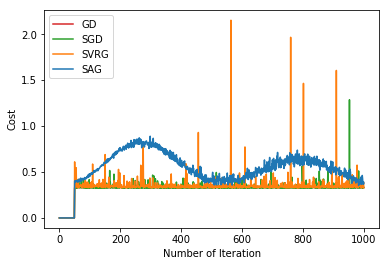

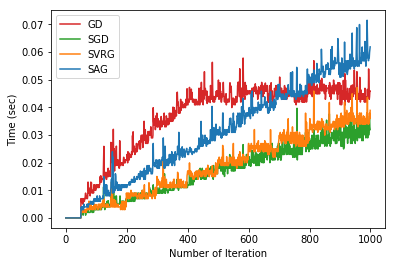

In [693]:
## Executing the iterations and plot the cost function here:
I_max = 1000
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
w = np.random.rand(D,1)*0.01
for i in range(50,I_max):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="GD", mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test, Y_test, gd, lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SGD", mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test, Y_test, sgd, lambda_)

    ti[i,1] = end-start
    
    #---------------SVRG----------------
    start = time.time()
    svrg = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SVRG", mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test, Y_test, svrg, lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sag = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SAG", mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test, Y_test, sag, lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 


plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="C3")
l1 = plt.plot(ti[:,1],color="C2")
l2 = plt.plot(ti[:,2],color="C1")
l3 = plt.plot(ti[:,3],color="C0")
# complete other plots here:

plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()
    
    
    

In [ ]:
## Tunning the hyper-paramter here:

In [ ]:
## Comparing different optimizers here: 